<img style="float: right;" src="../bvlecture_exercises/htwlogo.jpg">

# Exercise: spam classification

**Author**: _Erik Rodner_<br>
**Lecture**: Computer Vision and Machine Learning I

In the following exercise, you need to implement your first machine learning system: classical spam classification.
We will use a dataset of SMS messages that have been tagged as either ``spam`` or ``ham`` (normal message).
The dataset was used in the kaggle challenge https://www.kaggle.com/uciml/sms-spam-collection-dataset and is originally from http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/.

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from os.path import isfile
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pylab as plt
import numpy as np
from scipy.sparse import find
from sklearn import svm

### Download and show the dataset

The following code snipplet downloads the zip file and uncompresses it, such that you have the dataset on your jupyter notebook machine.

In [2]:
if not isfile("SMSSpamCollection.txt"):
    print ("Downloading dataset...")
    dataset_url = "https://www.dt.fee.unicamp.br/~tiago/smsspamcollection/smsspamcollection.zip"
    with urlopen(dataset_url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('.')

Pandas is a great tool for reading and managing tables.

In [3]:
df = pd.read_csv("SMSSpamCollection.txt", delimiter="\t", names=["label", "sentence"])
df.head()

,label,sentence
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Splitting and inspecting the dataset

We need to split the dataset into a training set and a test set.
``scikit-learn`` provides multiple tools for this very first task in machine learning. The following line uses stratified sampling - can you guess why?

In [4]:
train_indices, test_indices = train_test_split(df.index, train_size=0.01, stratify=df["label"], random_state=42)

Text(0.5, 1.0, 'test data')

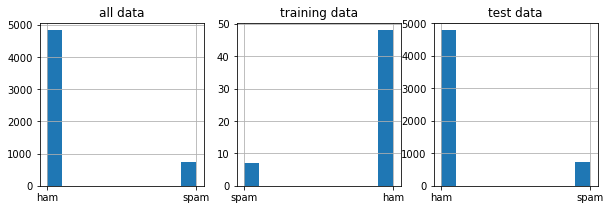

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
df["label"].hist()
plt.title("all data")
plt.subplot(1,3,2)
df["label"][train_indices].hist()
plt.title("training data")
plt.subplot(1,3,3)
df["label"][test_indices].hist()
plt.title("test data")

### Converting text to vectors

One way to deal with text is to convert it into proper vectors, but how?
We use a bag-of-words feature extractor in the following. First it generates a vocabulary $V = \{\text{word}_1, \text{word}_1, ..., \text{word}_n \}$ based on all training sentences (all words but without so called stop-words). Then, all words are counted in each sentence individually. A single feature $x_k$ in an example $\mathbf{x}$ is then defined as the occurrences of the word $\text{word}_k$ in the sentence. Can you spot any problems here?

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features=10)

y_train = df["label"][train_indices].array
X_train_counts = count_vect.fit_transform(df["sentence"][train_indices])

feature_dim = X_train_counts.shape[1]
X_train_counts.shape

(55, 10)

We remember which index corresponds to which word in the vocabulary:

In [7]:
index_to_word = {v: k for k, v in count_vect.vocabulary_.items()}
index_to_word[feature_dim//2]

'that'

In [8]:
def visualize_example(x, title=""):
    """ Helper function for visualizing bag-of-word vectors """
    _, x_indices, x_values = find(x)
    words = ",".join( [index_to_word[i] for i in x_indices ])
    if len(words)>20:
        words = words[:20] + "..."
    plt.figure(figsize=(10, 3))
    plt.bar(x_indices, height=x_values, width=20.0)
    plt.xlabel("indices of the vector, word index in vocabulary")
    plt.title(title + "; " + words)
    plt.show()

Let's inspect some examples:

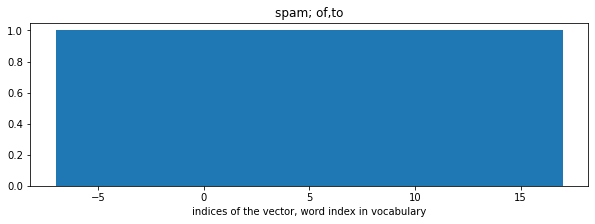

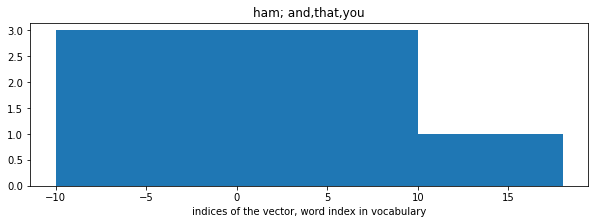

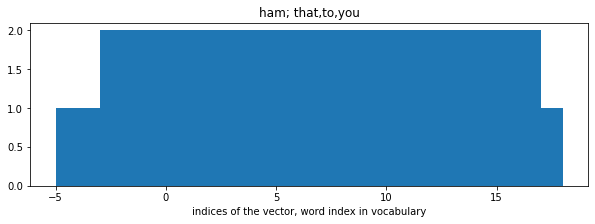

In [9]:
for i in [0, 5, 7]:
    visualize_example(X_train_counts[i,:], y_train[i])

### Train the classifier

In [10]:
classifier = svm.LinearSVC()
np.random.shuffle(y_train)
classifier.fit(X_train_counts, y_train)

LinearSVC()

### Inspect the classifier

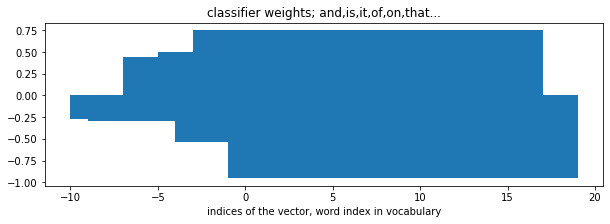

the
to
your


In [11]:
visualize_example(classifier.coef_, "classifier weights")
_, most_important_coef = np.where(np.abs(classifier.coef_)>0.5)
important_words = [index_to_word[i] for i in most_important_coef ]
print ("\n".join(important_words))

### Test and evaluate the classifier

Now let's transform the test data and predict the classification results

In [12]:
X_test_counts = count_vect.transform(df["sentence"][test_indices])
y_test = df["label"][test_indices]

In [13]:
y_predict = classifier.predict(X_test_counts)

### Visualize the results

A confusion matrix is a good way to obtain an overview of the classification results.

This is how it should look like:
<img src="spam_solution.png">

In [14]:
C = confusion_matrix(y_test, y_predict)

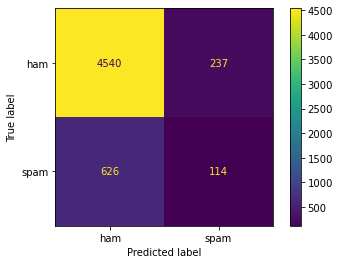

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=C, display_labels=classifier.classes_)
disp.plot() 

## What is the accuracy??